In [4]:
%matplotlib inline

In [3]:
import json
import math
import os
import random
import time
from collections import Counter, namedtuple
from itertools import count
from typing import Dict, Optional
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from env import GameEnv

In [3]:
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
  

In [5]:
class Actor(nn.Module):
    def __init__(self, input_shape, outputs):
        super().__init__()

        self.outputs = outputs
        self.fn1 = nn.Linear(input_shape, 300)
        self.fn2 = nn.Linear(300, 300)
        self.fn3 = nn.Linear(300, 200)
        self.fn4 = nn.Linear(200, 200)
        self.fn5 = nn.Linear(200, 100)
        self.fn6 = nn.Linear(100, 100)

        self.head = nn.Linear(100, outputs)


    def forward(self, x):
        x = F.relu(self.fn1(x.view(x.size(0), -1)))
        x = F.relu(self.fn2(x))
        x = F.relu(self.fn3(x))
        x = F.relu(self.fn4(x))
        x = F.relu(self.fn5(x))
        x = F.relu(self.fn6(x))

        return F.softmax(self.head(x), dim=1)

class Critic(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.fn1 = nn.Linear(input_shape, 300)
        self.fn2 = nn.Linear(300, 300)
        self.fn3 = nn.Linear(300, 200)
        self.fn4 = nn.Linear(200, 200)
        self.fn5 = nn.Linear(200, 100)
        self.fn6 = nn.Linear(100, 100)

        self.head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fn1(x.view(x.size(0), -1)))
        x = F.relu(self.fn2(x))
        x = F.relu(self.fn3(x))
        x = F.relu(self.fn4(x))
        x = F.relu(self.fn5(x))
        x = F.relu(self.fn6(x))

        return self.head(x)

In [5]:
  def optimize_model(q_val):
        values = torch.stack(memory.values)
        q_vals = np.zeros((len(memory), 1))

        # target values are calculated backward
        # it's super important to handle correctly done states,
        # for those cases we want our to target to be equal to the reward only
        q_val = q_val.item()
        for i, (_, _, reward, done) in enumerate(memory.reversed()):
            q_val = reward + GAMMA*q_val*(1.0-done)
            # store values from the end to the beginning
            q_vals[len(memory)-1 - i] = q_val

        advantage = torch.Tensor(q_vals).to(device) - values

        critic_loss = advantage.pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = (-torch.stack(memory.log_probs)
                      * advantage.detach()).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

In [6]:
def train(num_episodes):
    max_steps = 5000
    global max_steps_count
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        steps = 0
        if max_steps_count > 2000:
            break
        current_board = get_state(env)
        for t in count():
            probs = actor(current_board)
            dist = torch.distributions.Categorical(probs=probs)
            action = dist.sample()

            _, reward, done, _ = env.step(action.item())
            steps += 1
            memory.add(dist.log_prob(action), critic(current_board), reward, done)
            current_board = get_state(env)

            if done or (steps % max_steps == 0):
                if (steps % max_steps == 0):
                    max_steps_count +=1
                    print(f"max steps reached {max_steps_count}")

                last_q_val = critic(current_board)
                optimize_model(last_q_val)
                memory.clear()
                episode_scores.append(env.score)
                highest_scores.append(env.highest())
                plot_scores()
                break
        

    env.close()

In [7]:
def plot_scores(save=None):
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(highest_scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Highest Scores')
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

    plt.pause(0.001)  # pause a bit so that plots are updated

    display.clear_output(wait=True)

In [8]:
def write_results(log_dir):
    try:
        os.makedirs(log_dir)
    except OSError:
        pass
    plot_scores(save=f"{log_dir}/plot.png")
    torch.save(actor, f"{log_dir}/actor.pt")
    torch.save(critic, f"{log_dir}/critic.pt")
    torch.save(actor_optimizer, f"{log_dir}/actor_optimizer.pt")
    torch.save(critic_optimizer, f"{log_dir}/critic_optimizer.pt")

    with open(f"{log_dir}/highest_scores.json", "w") as json_file:
        scores = {str(k): v for k, v in Counter(
            highest_scores).items()}
        print(scores)
        json.dump(scores, json_file)

In [6]:
def evaluate(steps):
    episode_scores = []
    highest_scores = []
    for i in range(steps):
        env.reset()
        steps_done = 0
        for t in count():
            probs = actor(get_state(env))
            dist = torch.distributions.Categorical(probs=probs)
            action = dist.sample()
            board, reward, done, info = env.step(action.item())
            steps_done += 1
            if done or steps_done > 10000:
                if steps_done > 10000:
                    print("max steps reached")
                env.render()
                episode_scores.append(env.score)
                highest_scores.append(env.highest())
                break
    print(Counter(highest_scores))
    plt.plot(highest_scores)

In [15]:
num_episodes = 1000
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Start training setup

In [13]:
# 4*16 matrix
def get_state(env: GameEnv):
    with np.errstate(divide='ignore'):
        board = np.where(env.board != 0, np.log2(env.board).astype(np.int), 0)
    board = np.vectorize(np.binary_repr)(board, width=4).astype(str)
    board = np.array([list(''.join(line)) for line in board]).astype(np.int)
    return torch.from_numpy(np.ascontiguousarray(board)).unsqueeze(0).float().to(device)

In [9]:
class Reward1():
    @staticmethod
    def reward_function(score) -> float:
        return score / 80
    
    @staticmethod
    def tile_merge_reward(value_pair) -> float:
        return np.log2(value_pair[0])

    @staticmethod
    def final_state_reward(score: float = None) -> float:
        return 0.

    @staticmethod
    def invalid_move_reward() -> float:
        return 0.

env = GameEnv(reward_class=Reward1)

In [13]:
episode_scores = []
highest_scores = []
memory = Memory()
steps_done = 0
n_actions = env.action_space.n
actor = Actor(4*16, n_actions).to(device)
critic = Critic(4*16).to(device)
actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
max_steps_count = 0

In [14]:
import logging
logging.basicConfig(level=logging.DEBUG, filename="run.log")

In [15]:
for i in range(10):
    train(num_episodes)
    write_results(f"runs/a2c1/{i}")

{'256': 1815, '128': 4301, '32': 520, '64': 3030, '16': 15, '512': 318, '1024': 1}


/home/matei/anaconda3/envs/RL/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/matei/anaconda3/envs/RL/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Critic. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [7]:
import torch
model = torch.load("runs/a2c1/9/actor.pt")
model.eval()

Actor(
  (fn1): Linear(in_features=64, out_features=300, bias=True)
  (fn2): Linear(in_features=300, out_features=300, bias=True)
  (fn3): Linear(in_features=300, out_features=200, bias=True)
  (fn4): Linear(in_features=200, out_features=200, bias=True)
  (fn5): Linear(in_features=200, out_features=100, bias=True)
  (fn6): Linear(in_features=100, out_features=100, bias=True)
  (head): Linear(in_features=100, out_features=4, bias=True)
)

In [11]:
actor = model

Score: 4.287500000000006
Highest: 128
[[  2   8   2   4]
 [  8  16   8   2]
 [ 32  64  16   8]
 [ 64 128  64  16]]
Score: 4.512500000000004
Highest: 128
[[  2   4   8   2]
 [ 16  32  16   4]
 [ 32  64  32  16]
 [ 64 128   4  32]]
Score: 8.287500000000007
Highest: 256
[[  4   8   4   2]
 [  8   4  16   4]
 [ 16  32 128   8]
 [ 32 128 256 128]]
Score: 3.425000000000002
Highest: 128
[[  2   8   4   2]
 [  8  16   2   8]
 [ 16  32   8   2]
 [ 32 128  64  32]]
max steps reached
Score: 2.1375
Highest: 128
[[  0   0   0   0]
 [  2   4   2   4]
 [  4   8  32  16]
 [  8   2  16 128]]
Score: 5.812500000000007
Highest: 256
[[  2   4   8   2]
 [  4   8  16   4]
 [  8  32   4   8]
 [256 128  64  16]]
Score: 3.537500000000002
Highest: 128
[[  2   4   8   2]
 [  4   8  16   4]
 [  8  16  32   8]
 [ 32  64 128  32]]
Score: 10.899999999999993
Highest: 512
[[  2   4   8   2]
 [  8  32  16   4]
 [ 16  64  32  16]
 [128 512 128  32]]
Score: 7.53750000000001
Highest: 256
[[  2   8   4   2]
 [  8  32  16   

Score: 3.8500000000000028
Highest: 128
[[  2   4   8   2]
 [  4   8  16   8]
 [  8  16  32  16]
 [ 16  64 128  64]]
Score: 5.100000000000007
Highest: 128
[[  2   4   8   2]
 [  8  32  16   8]
 [ 32  64  32  16]
 [ 64 128  64  32]]
Score: 5.325000000000003
Highest: 256
[[  2   4   2   4]
 [  4  16   8   2]
 [  8 256  32   4]
 [128  32   2  16]]
Score: 8.712500000000007
Highest: 256
[[  2   4   8   2]
 [  4  32  16   8]
 [ 16  64 128  16]
 [ 64 128 256  64]]
Score: 4.262500000000003
Highest: 128
[[  2   8   4   2]
 [  8  32  16   4]
 [ 16  64  32  16]
 [ 32   2 128  64]]
Score: 6.912500000000009
Highest: 256
[[  4   2   8   2]
 [  2   8  16   4]
 [  4  16 128   2]
 [ 16 128 256  64]]
Score: 4.712500000000005
Highest: 128
[[  4   2   4   2]
 [  8  16   8   4]
 [ 32  64  32  16]
 [ 64 128  64  32]]
Score: 7.375000000000012
Highest: 256
[[  2   8   4   2]
 [  8  32  16   8]
 [ 32  64 128  16]
 [ 64 256   4  64]]
Score: 8.262500000000014
Highest: 256
[[  4   2   4   2]
 [  2   4   2   8]
 [ 

Score: 2.2750000000000004
Highest: 128
[[  2   4   2   4]
 [  4   8   4   8]
 [  8  32  16   2]
 [ 32   2 128   4]]
Score: 6.762500000000011
Highest: 256
[[  2   4   8   4]
 [  8   2   4  16]
 [ 16  32  64   8]
 [ 32 256 128  64]]
Score: 10.174999999999988
Highest: 512
[[  2   4   2   4]
 [  8  16   8   2]
 [ 16  32  64  16]
 [ 64 128 512  64]]
max steps reached
Score: 3.112500000000003
Highest: 128
[[  0   0   0   0]
 [  2   4   8   2]
 [  4   8  32  16]
 [ 16  64 128  32]]
max steps reached
Score: 9.812500000000005
Highest: 512
[[  0   0   0   0]
 [  2  16   4   2]
 [  8   2  32   4]
 [  2 512 256  32]]
Score: 6.375000000000008
Highest: 256
[[  4   2   4   2]
 [  8   4   8  16]
 [ 16  64  32   2]
 [ 32 256 128  32]]
Score: 9.450000000000001
Highest: 512
[[  4   8   4   2]
 [  8   4  16   8]
 [ 16  64   4   2]
 [ 64 128 512  32]]
Score: 3.1750000000000003
Highest: 64
[[ 2  4  8  2]
 [ 8 32 16  8]
 [32  8 64 32]
 [64 16 32 16]]
Score: 4.400000000000004
Highest: 256
[[  2   8   4   2]
 

Score: 2.8250000000000006
Highest: 64
[[ 4  8  4  2]
 [ 2 16 32  8]
 [16 32 64 16]
 [32 64  8  2]]
max steps reached
Score: 3.600000000000002
Highest: 128
[[  0   0   0   0]
 [  2   4   8   2]
 [  4   8  64   4]
 [ 64   4 128  64]]
Score: 4.025000000000002
Highest: 128
[[  2   4   8   2]
 [  4  64  16   4]
 [  8   4  32  16]
 [ 32 128  64  32]]
Score: 3.7125000000000012
Highest: 128
[[  2   8   4   2]
 [  8  16   8   4]
 [ 32  64  32   8]
 [  4 128   2  64]]
max steps reached
Score: 6.8875000000000055
Highest: 256
[[  0   0   0   0]
 [  2   8   4   2]
 [ 16  32  16   8]
 [128 256 128  32]]
Score: 6.112500000000007
Highest: 256
[[  2   4   2   4]
 [  4   8  16   8]
 [ 16  32  64  16]
 [ 32  64 256  64]]
Score: 3.2250000000000023
Highest: 128
[[  2   4   8   2]
 [  4   8  16   4]
 [  8  64   4   8]
 [ 32 128  16  32]]
Score: 0.9249999999999996
Highest: 32
[[ 4  2  4  2]
 [ 2  4 16  4]
 [ 4 16  2 16]
 [16 32  8  2]]
Score: 2.9250000000000007
Highest: 128
[[  2   8   4   2]
 [  4  16   8  

Score: 7.037500000000005
Highest: 256
[[  2   4   8   2]
 [  4   8   2   4]
 [ 16 128  64   8]
 [ 32   2 256 128]]
Score: 9.662499999999998
Highest: 512
[[  2   4  16   2]
 [  8  16  32   8]
 [ 16  32  64  16]
 [ 32  64 512  64]]
Score: 5.987500000000005
Highest: 256
[[  4   2   4   2]
 [  2  16   8   4]
 [  4  64  32   8]
 [ 32 256 128  16]]
Score: 10.874999999999988
Highest: 512
[[  2   4   8   4]
 [  4  16   4   2]
 [  2 128  16   4]
 [  8 512 256  16]]
Score: 7.125000000000011
Highest: 256
[[  2   4   8   2]
 [  4  32  16   8]
 [ 16  64  32  16]
 [ 64 128 256  32]]
Score: 4.812500000000006
Highest: 256
[[  2   8   4   2]
 [  4  32  16   8]
 [  8  64   2  16]
 [ 16 256  32   2]]
Score: 5.887500000000008
Highest: 256
[[  2   4  16   2]
 [  4  64   8   4]
 [ 32 256  16   8]
 [ 64   2  64  32]]
Score: 7.875000000000013
Highest: 256
[[  2   4   8   2]
 [  8  16  32   8]
 [ 16  64 128  32]
 [ 32   2 256 128]]
Score: 6.012500000000012
Highest: 256
[[  2   4   8   2]
 [  8  64  16   4]
 [ 

Score: 7.41250000000001
Highest: 256
[[  2   8   4   2]
 [  8  32  16   8]
 [ 16   4  64  32]
 [ 64 128 256  64]]
Score: 3.2500000000000004
Highest: 128
[[  2   8   2   4]
 [  4  16   8   2]
 [  8  32  16   8]
 [ 64 128  32  16]]
Score: 1.824999999999999
Highest: 64
[[ 2  4  2  4]
 [ 4  8  4  2]
 [ 8 32  8  4]
 [32 64 32  8]]
Score: 6.950000000000007
Highest: 256
[[  2   8   4   2]
 [ 16  32  16   4]
 [ 32  64  32   8]
 [256 128   2  64]]
Score: 4.550000000000003
Highest: 128
[[  4   8   4   2]
 [  8  16  32   4]
 [ 32 128  64  16]
 [ 64   8   4  64]]
Score: 5.487500000000006
Highest: 256
[[  2   8   4   2]
 [  8  32  16   4]
 [ 32  64  32  16]
 [  2  32 256  32]]
max steps reached
Score: 1.2374999999999996
Highest: 64
[[ 0  0  0  0]
 [ 2  4  8  2]
 [32  2 16  4]
 [ 8 64  2  8]]
Score: 3.8375000000000017
Highest: 128
[[  2   8   4   2]
 [  4  16   8   4]
 [  8  32   4  16]
 [ 64 128  64  32]]
max steps reached
Score: 6.612500000000009
Highest: 256
[[  0   0   0   0]
 [  2   4  16   4]


Score: 12.624999999999984
Highest: 512
[[  4   2   8   4]
 [  8  32  16   2]
 [ 32 128  64   8]
 [128 512 128  64]]
max steps reached
Score: 7.58750000000001
Highest: 256
[[  2   4   2   4]
 [  4  16  32   2]
 [  8  32  64  32]
 [ 64 128 256  64]]
Score: 12.58749999999999
Highest: 512
[[  4   2   4   2]
 [  8  32  16   4]
 [ 32 128  64  32]
 [128 512 128  64]]
Score: 7.112500000000009
Highest: 256
[[  2   8   2   4]
 [  4  32  16   8]
 [ 16  64   2  16]
 [ 64 128 256  64]]
Score: 5.025000000000005
Highest: 256
[[  2   8   4   2]
 [  4  32   8   4]
 [  8  64  32  16]
 [  2  32 256  32]]
Score: 10.624999999999996
Highest: 512
[[  2   4   8   2]
 [  8  16  32   4]
 [ 16  32  64  32]
 [ 64 128 512  64]]
Score: 8.750000000000002
Highest: 512
[[  4   2   4   2]
 [  8  16   8   4]
 [ 16  64   2  16]
 [ 64 512  64  32]]
max steps reached
Score: 2.237499999999999
Highest: 64
[[ 0  0  0  0]
 [ 2  4 16  4]
 [ 8 32  8 16]
 [16 64 16 64]]
Score: 2.8375000000000012
Highest: 128
[[  4   2  16   2]
 [

max steps reached
Score: 2.4874999999999994
Highest: 128
[[  0   0   0   0]
 [  2   4  16   2]
 [  8  32   8   4]
 [ 32   2 128  32]]
Score: 3.137500000000002
Highest: 128
[[  2   4   8   2]
 [  4   8  16  32]
 [  8  16  64   2]
 [ 32 128   8   4]]
Score: 4.087500000000002
Highest: 128
[[  2   4   2   4]
 [  4  32   8   2]
 [  8  16  64  16]
 [ 32  64 128  32]]
max steps reached
Score: 3.050000000000001
Highest: 128
[[  0   0   0   0]
 [  4   8   4   2]
 [  8  64  16   4]
 [ 32   8 128  32]]
Score: 4.425000000000003
Highest: 128
[[  2   4   8   2]
 [  4   8   2   4]
 [  8  32 128   8]
 [ 32 128   2  64]]
Score: 10.362499999999994
Highest: 512
[[  2   8   4   2]
 [  4  16   2   8]
 [ 32 128  16   4]
 [ 64 512 128  16]]
Score: 4.062500000000003
Highest: 256
[[  2   4   8   2]
 [ 16   8   2   8]
 [ 32  16   8   2]
 [  8   4 256  32]]
Score: 3.725000000000003
Highest: 128
[[  2   4   8   2]
 [  4   8  16   8]
 [  8  32   2  16]
 [ 16  64 128  64]]
Score: 5.625000000000005
Highest: 256
[[  

Score: 3.2500000000000004
Highest: 128
[[  2   8   4   2]
 [  8  16   8   4]
 [ 16  64  16   8]
 [ 32   2 128  32]]
Score: 6.462500000000008
Highest: 256
[[  2   4   8   2]
 [  4   8  32   4]
 [ 16  32  64  32]
 [ 32  64 256  64]]
max steps reached
Score: 6.58750000000001
Highest: 256
[[  0   0   0   0]
 [  2   4   8   2]
 [  8  16  32   8]
 [128 256 128  32]]
max steps reached
Score: 1.3749999999999996
Highest: 64
[[ 0  0  0  0]
 [ 2  8  2  4]
 [ 8 16  4  2]
 [16 64 32  8]]
Score: 3.637500000000004
Highest: 128
[[  2   8   4   2]
 [  4  16  32   4]
 [ 16  32  64  16]
 [  2  16 128  32]]
max steps reached
Score: 7.300000000000011
Highest: 256
[[  0   0   0   0]
 [  2  16   2   4]
 [  4  32  64   8]
 [128 256 128  32]]
Score: 2.825000000000002
Highest: 128
[[  2   8   4   2]
 [  4  16   8   4]
 [  8  32   2   8]
 [ 32 128  16  32]]
Score: 3.8875000000000024
Highest: 128
[[  2   8   4   2]
 [  4  16   8   4]
 [  8  64  32  16]
 [ 64 128   2  32]]
Score: 2.987500000000001
Highest: 128
[[ 

Score: 9.337499999999995
Highest: 256
[[  2   8   4   2]
 [  8  16   8   4]
 [ 32 128  64  16]
 [128 256 128  64]]
Score: 7.100000000000012
Highest: 256
[[  2   8   4   2]
 [  4  32   8   4]
 [ 16  64  32  16]
 [ 64 128 256  32]]
Score: 13.73749999999999
Highest: 512
[[  2   4   8   4]
 [  8  32  16   8]
 [ 32 128  32  16]
 [128 512 256  64]]
Score: 7.2125000000000155
Highest: 256
[[  4   8   4   2]
 [  8  32  16   8]
 [ 16  64  32  16]
 [ 64 128 256  32]]
Score: 3.8375000000000017
Highest: 128
[[  4   2   4   2]
 [  8  16   8   4]
 [ 16 128  32  16]
 [ 64   4  64  32]]
max steps reached
Score: 5.5125000000000055
Highest: 256
[[  0   0   0   0]
 [  4   8   4   2]
 [  8 128  32  16]
 [256  32   4  32]]
Score: 3.2625000000000015
Highest: 64
[[ 4  8  4  2]
 [ 2 32  8  4]
 [ 4 64 32  8]
 [64 16 64 32]]
Score: 8.387500000000015
Highest: 256
[[  2   4   8   2]
 [  8  32  16   8]
 [ 16 128  32  16]
 [ 64 256 128  64]]
Score: 3.450000000000003
Highest: 128
[[  2   8   4   2]
 [  8  16   8   4]

max steps reached
Score: 5.70000000000001
Highest: 256
[[  0   0   0   0]
 [  4   2   8   2]
 [ 16  32  16   8]
 [ 32 256 128  32]]
max steps reached
Score: 4.900000000000006
Highest: 256
[[  0   0   0   0]
 [  4   8   4   2]
 [  8  32  16   8]
 [ 32  64 256  32]]
Score: 3.9500000000000024
Highest: 128
[[  2   8   4   2]
 [ 16  32  16   4]
 [  2  16  64   8]
 [ 32 128   4  64]]
Score: 6.562500000000012
Highest: 256
[[  2   8   4   2]
 [  4   2   8   4]
 [ 16   4  64  32]
 [ 32 128 256  64]]
Score: 2.6499999999999995
Highest: 128
[[  2   4   2   8]
 [  4   2   8   2]
 [ 16   4  32   4]
 [  2  32 128  32]]
Score: 3.5875000000000026
Highest: 128
[[  2   4   8   2]
 [  8  32  16   8]
 [ 16  64   4  16]
 [ 32 128   2  32]]
Score: 2.3125000000000004
Highest: 64
[[ 4  2  8  2]
 [ 2  4 16  8]
 [ 8 16 32 16]
 [16 32 64 32]]
Score: 10.212500000000002
Highest: 512
[[  2   8   4   2]
 [  8  16  32   8]
 [ 16  32  64  16]
 [ 64 512 128  32]]
Score: 7.675000000000012
Highest: 256
[[  2   8   4   2]


Score: 17.637499999999946
Highest: 1024
[[   2    4    2    4]
 [   8   16    8    2]
 [   4   32   64   32]
 [  32  256 1024   64]]
Score: 1.4499999999999993
Highest: 64
[[ 2  4  2  8]
 [ 4  8  4  2]
 [ 8  2 16  4]
 [16 64 32  8]]
Score: 5.987500000000009
Highest: 256
[[  2   4   8   2]
 [  8  16   2   4]
 [  4  64  32  16]
 [ 64 256  64  32]]
Score: 6.275000000000005
Highest: 256
[[  2   8   4   2]
 [  4  16  32   8]
 [ 16  64 128   2]
 [ 32 256   4  32]]
Score: 4.212500000000004
Highest: 128
[[  2   8   4   2]
 [  4  32   8   4]
 [  8  64  32   8]
 [ 32 128  64  32]]
Score: 7.11250000000001
Highest: 256
[[  2   8   4   2]
 [  8  16  32   8]
 [ 16   4  64  32]
 [ 32 128 256  64]]
Score: 12.649999999999975
Highest: 512
[[  2   8   4   2]
 [ 16  32   8   4]
 [ 32  64  32  16]
 [128 512 256  32]]
Score: 8.525000000000007
Highest: 256
[[  2   8   4   2]
 [  8  16   8   4]
 [ 16 128  16   8]
 [128 256 128  64]]
Score: 8.712500000000004
Highest: 512
[[  2   4   8   2]
 [  4  32  16   8]
 [

Score: 3.2625000000000015
Highest: 128
[[  2   8   2   4]
 [  8  16   4   2]
 [ 16  32  16   8]
 [  4  64 128  32]]
Score: 16.049999999999972
Highest: 512
[[  2   4   8   4]
 [  4   8  32   8]
 [ 64 256  64  32]
 [128 512 256  64]]
Score: 3.4000000000000026
Highest: 128
[[  2   4   8   2]
 [  4   8  16   4]
 [ 16   2  32   8]
 [ 32  64 128  32]]
Score: 3.3250000000000015
Highest: 128
[[  2   8   4   2]
 [ 16  32  16   4]
 [ 32   8  32   2]
 [128  32   8  32]]
Score: 5.650000000000009
Highest: 256
[[  2   8   4   2]
 [  8  16  32  16]
 [ 16  64  16   4]
 [ 32 256  64  16]]
Score: 8.337500000000011
Highest: 512
[[  2   4   8   2]
 [  4  32  16   4]
 [ 16   2  32   8]
 [  2  64 512  64]]
Score: 2.7750000000000004
Highest: 128
[[  2   4   2   8]
 [  4   8   4   2]
 [ 16  32  16   4]
 [ 32   8 128  32]]
Score: 7.23750000000001
Highest: 256
[[  2   8   4   2]
 [  4  32  16   4]
 [ 16 128   2  16]
 [ 32 256 128  32]]
Score: 5.612500000000008
Highest: 256
[[  2   4   2   4]
 [  4  16  32   8]


Score: 14.299999999999976
Highest: 512
[[  2   4   8   2]
 [  4  16  32   4]
 [ 32 128  64  32]
 [128 256 512  64]]
Score: 6.71250000000001
Highest: 256
[[  2   4   2   8]
 [  4   8  16   2]
 [  8  64 128  16]
 [ 64 256   2  64]]
Score: 5.2625000000000055
Highest: 256
[[  4   2   4   2]
 [  8   4  16   4]
 [  2  64  32   8]
 [ 16 256  64  32]]
Score: 5.450000000000008
Highest: 256
[[  2   8   4   2]
 [  4  16  32   8]
 [ 16  32   4   2]
 [ 64 256  64  16]]
Score: 6.975000000000015
Highest: 256
[[  2   4   8   4]
 [ 16  32  16   8]
 [  4  16  64  16]
 [ 64 256 128  32]]
max steps reached
Score: 4.1125000000000025
Highest: 128
[[  0   0   0   0]
 [  8   2   8   4]
 [ 16  32  64  16]
 [ 32  64 128  32]]
Score: 4.075000000000004
Highest: 128
[[  4   8   4   2]
 [  8  32  16   8]
 [ 32  64   2  16]
 [  2 128  64  32]]
Score: 8.762500000000006
Highest: 256
[[  2   8   4   2]
 [  8  16  32   4]
 [ 16  64 128  32]
 [ 64 128 256  64]]
Score: 7.187500000000006
Highest: 256
[[  4   2   8   4]
 [ 

Score: 6.962500000000009
Highest: 256
[[  2   4   2   4]
 [  8  32   8   2]
 [ 32  64  16   4]
 [ 64 256 128  32]]
Score: 14.087499999999975
Highest: 512
[[  4   8   4   2]
 [  8  16  32   8]
 [ 32 128  64  16]
 [256 512 128  64]]
Score: 4.662500000000003
Highest: 128
[[  2   4   2   4]
 [  4  32   4   2]
 [ 16  64  32  16]
 [ 64 128  64  32]]
Score: 3.3250000000000015
Highest: 128
[[  2   4   8   2]
 [  4   8  16   4]
 [  8  16  64  16]
 [  2  32 128  32]]
max steps reached
Score: 1.5624999999999998
Highest: 64
[[ 0  0  0  0]
 [ 2  4  2  4]
 [ 8 32  4  8]
 [32 64  8 16]]
Score: 5.5875000000000075
Highest: 256
[[  2   4   2   4]
 [  8  16   8   2]
 [ 16  32  16   8]
 [  4 128 256  32]]
Score: 4.750000000000006
Highest: 128
[[  2   8   4   2]
 [  4  64   8   4]
 [  8 128  32  16]
 [ 32   2 128  32]]
Score: 4.537500000000004
Highest: 128
[[  2   8   4   2]
 [  4  16   8   4]
 [ 16  32  64  16]
 [ 32  64 128  64]]
Score: 2.6625000000000014
Highest: 128
[[  2   4   8   4]
 [  8  32  16   8

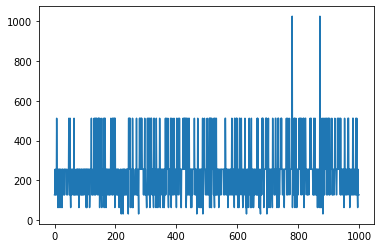

In [16]:
evaluate(1000)

In [22]:
class Reward2():
    @staticmethod
    def reward_function(score) -> float:
        return min(score/4., 1.)
    
#     number of tiles mergesd
    @staticmethod
    def tile_merge_reward(value_pair) -> float:
        return 1.

    @staticmethod
    def final_state_reward(score: float = None) -> float:
        return -1.

    @staticmethod
    def invalid_move_reward() -> float:
        return 0.

env = GameEnv(reward_class=Reward2)

In [25]:
episode_scores = []
highest_scores = []
memory = Memory()
steps_done = 0
n_actions = env.action_space.n
actor = Actor(4*16, n_actions).to(device)
critic = Critic(4*16).to(device)
actor_optimizer = optim.RMSprop(actor.parameters(), lr=0.0001)
critic_optimizer = optim.RMSprop(critic.parameters(), lr=0.0001)
max_steps_count = 0

In [26]:
for i in range(10):
    train(num_episodes)
    write_results(f"runs/a2c2/{i}")

{'64': 2823, '128': 4400, '256': 1892, '32': 483, '16': 22, '512': 377, '1024': 3}


/home/matei/anaconda3/envs/RL/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/matei/anaconda3/envs/RL/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Critic. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


Score: 82.0
Highest: 256
[[128  32   4   2]
 [256  64  32   8]
 [128  32  16   4]
 [ 32  16   4   2]]
Score: 90.0
Highest: 256
[[128  32   4   2]
 [256 128  32   4]
 [128  32  16   8]
 [ 32  16   4   2]]
max steps reached
Score: 31.75
Highest: 128
[[ 16   8   2   0]
 [128  64   8   0]
 [ 32  16   2   0]
 [ 16   8   4   0]]
Score: 90.75
Highest: 256
[[ 64  32   8   2]
 [256 128  32   4]
 [128  64  16   8]
 [ 64  16   8   4]]
Score: 27.75
Highest: 64
[[32 16  4  2]
 [ 2 64  2 16]
 [64 16 32  4]
 [ 8  2  8  2]]
Score: 18.5
Highest: 64
[[ 8  4  2  4]
 [64 16  8  2]
 [ 2 32 16  4]
 [32  4  2  8]]
Score: 64.0
Highest: 256
[[ 16   8   4   2]
 [  2  64  32   4]
 [256  32  16   8]
 [128  16   8   2]]
Score: 35.75
Highest: 128
[[  8   4   8   2]
 [ 64   8   2   4]
 [128  32   4   2]
 [ 64  16   2   4]]
max steps reached
Score: 51.0
Highest: 128
[[ 64  16   8   2]
 [  4 128   4   0]
 [128  16  32   4]
 [ 64   8   2   4]]
Score: 28.5
Highest: 128
[[ 32   8   4   2]
 [  2  16   8   4]
 [128  32  16

max steps reached
Score: 37.0
Highest: 128
[[ 32  16   4   0]
 [128  64   8   0]
 [ 64   8   4   0]
 [ 16   4   2   0]]
Score: 41.25
Highest: 128
[[ 64   8   4   2]
 [  4 128  16   8]
 [  2  64  32   4]
 [ 32  16   8   2]]
Score: 112.5
Highest: 512
[[ 32   8   4   2]
 [  4  32   8  16]
 [512 256  64   4]
 [ 64  16   4   2]]
Score: 48.0
Highest: 128
[[ 64  32   2   4]
 [  4  64  32   8]
 [ 32 128   8   4]
 [  2  64   4   2]]
Score: 63.25
Highest: 256
[[ 64  16   8   4]
 [256  32  16   8]
 [128   2  32   4]
 [  2   8   4   2]]
Score: 103.0
Highest: 512
[[ 64  32   8   2]
 [512 128  16   8]
 [ 64  32   8   4]
 [ 32   8   4   2]]
max steps reached
Score: 20.25
Highest: 64
[[32  8  2  0]
 [64  4 16  0]
 [32 16  4  0]
 [16  8  2  0]]
max steps reached
Score: 45.25
Highest: 128
[[ 32  16   2   0]
 [128  32   8   0]
 [ 16 128   2   0]
 [ 64   8   4   0]]
Score: 65.5
Highest: 256
[[  2  32   8   2]
 [  8  64  16   4]
 [128   8  32   2]
 [256  32   8   4]]
Score: 23.25
Highest: 64
[[ 4  2 16  4]

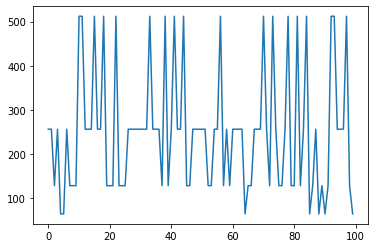

In [27]:
evaluate(100)

In [ ]:
# 4*4 matrix
def get_state(env: GameEnv):
    with np.errstate(divide='ignore'):
        board = np.where(env.board != 0, np.log2(env.board), 0)
        return torch.from_numpy(np.ascontiguousarray(board)).unsqueeze(0).float().to(device)

In [ ]:
# def state2tensor(state):
#     t = np.zeros((16, 16), dtype=np.float32)
#     for i, c in enumerate(state.flatten()):
#         t[c, i] = 1
#     t.resize(1, 16, 4, 4)
#     return t